In [35]:
from bokeh.charts import HeatMap, output_file, show
from bokeh.resources import CDN
from bokeh.embed import file_html, autoload_static
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import pickle
from bokeh.plotting import reset_output
from bokeh.io import output_notebook

import os

import holoviews as hv
from holoviews import streams
hv.extension()

# Heatmap of Tissues

- Read in DESeq2 corrected dataframe
- For each tissue:
    - Compute the cdist against every other tissue
    - Collapse cdist matrix into a scalar via np.median
    
- Create dataframe
    - Tissues A (a,a,a...,b,b,b...c,c,c)
    - Tissues B (a,b,c....a,b,c...a,b,c)
    - Average distance between all points

- Plot with Holoviews
    - Try export to HTML to check interactivity
   
   
## Prepare Inputs
### Read in DESeq2 Normalized Dataset

In [2]:
df = pd.read_csv('/mnt/rna-seq-analysis/data/xena/deseq2_normalized_tcga_gtex_counts.tsv', 
                 sep='\t', index_col=0)

In [3]:
exp_dir = '/mnt/rna-seq-analysis/data/tissue-pairs'
tissues = os.listdir(exp_dir)
tissues.remove('raw-counts')
tissues.remove('normalized')

### Subset by samples

In [4]:
samples = [x for x in df.columns if x.startswith('GTEX') 
           or (x.endswith('01') or x.endswith('11'))]
df = df[samples]

In [5]:
df = df.apply(lambda x: np.log2(x + 1))

In [6]:
tissue_map = pickle.load(open('../maps/pickles/tissue_map.pickle', 'rb'))

### Pull in metadata

In [7]:
metadata = pd.read_csv('/mnt/rna-seq-analysis/metadata/tcga_gtex_metadata_intersect.tsv', 
                       index_col=0, sep='\t')

In [19]:
def get_samples_for_tissue(metadata, tissue):
    """
    metadata - DataFrame of intersectional metadata
    tissue - list containing all names associated with tissue
    """
    name = '-'.join(tissue)
    return flatten([list(set(metadata[metadata.tissue == x].index) for x in tissue)])

def flatten(x):
    """
    Flattens a nested array into a single list

    :param list x: The nested list/tuple to be flattened.
    """
    result = []
    for el in x:
        if hasattr(el, "__iter__") and not isinstance(el, basestring):
            result.extend(flatten(el))
        else:
            result.append(el)
    return result

def filter_by_tissue(s, t):
    if t == 'normal':
        s = [x for x in s if x.endswith('-11')]
    elif t == 'tumor':
        s = [x for x in s if x.endswith('-01')]
    else:
        s = [x for x in s if x.startswith('GTEX')]
    return s

def create_heatmap_dataframe(df, t1, t2):
    tissue_a = []
    tissue_b = []
    dist = []
    for a in sorted(tissues):
        a = a.split('-')
        for b in sorted(tissues):
            b = b.split('-')
            # Collect samples for tissues a and b
            samples_a = get_samples_for_tissue(metadata, a)
            samples_b = get_samples_for_tissue(metadata, b)
            samples_a = [x for x in samples_a if x in df.columns]
            samples_b = [x for x in samples_b if x in df.columns]
            samples_a = filter_by_tissue(samples_a, t1)
            samples_b = filter_by_tissue(samples_b, t2)
            if samples_a and samples_b:
                df_a = df[samples_a].T  # Samples by Genes for cdist
                df_b = df[samples_b].T  # Samples by Genes for cdist
                dist.append(np.median(cdist(df_a, df_b)))  # Take median 
                tissue_a.append('-'.join(a))
                tissue_b.append('-'.join(b))
    hm = pd.DataFrame()
    hm[t1.capitalize()] = tissue_a
    hm[t2.capitalize()] = tissue_b
    x = dist
    hm['dist'] = (x-min(x))/(max(x)-min(x))  # Normalize
    # Invert distance scores 
    # We want dark spots to indicate strong relationships 
    # i.e. small multidimensional distance
    hm['dist'] = 1 - hm.dist
    return hm

## Relational Heatmap of TCGA Normals to GTEx

In [20]:
hm = create_heatmap_dataframe(df, 'normal', 'gtex')

In [21]:
dataset = hv.Dataset(hm, vdims=['dist'])

In [22]:
%opts HeatMap [width=700 height=500 logz=True fontsize={'xticks': '6pt'}, tools=['hover'] xrotation=90] (cmap='RdBu_r')
h = hv.HeatMap(dataset.aggregate(['Normal', 'Gtex'], np.mean))
h

:HeatMap   [Normal,Gtex]   (dist)

## Relational Heatmap of TCGA Normals to TCGA Tumor

In [23]:
hm = create_heatmap_dataframe(df, 'normal', 'tumor')
dataset = hv.Dataset(hm, vdims=['dist'])

In [24]:
%opts HeatMap [width=700 height=500 logz=True fontsize={'xticks': '6pt'}, tools=['hover'] xrotation=90] (cmap='RdBu_r')
h = hv.HeatMap(dataset.aggregate(['Normal', 'Tumor'], np.mean))
h

:HeatMap   [Normal,Tumor]   (dist)

## Relational Heatmap of GTEx to TCGA Tumor

In [25]:
hm = create_heatmap_dataframe(df, 'gtex', 'tumor')
dataset = hv.Dataset(hm, vdims=['dist'])

In [26]:
%opts HeatMap [width=700 height=500 logz=True fontsize={'xticks': '6pt'}, tools=['hover'] xrotation=90] (cmap='RdBu_r')
h = hv.HeatMap(dataset.aggregate(['Gtex', 'Tumor'], np.mean))
h

:HeatMap   [Gtex,Tumor]   (dist)

# Matplotlib Plots
For display in PDF and LaTeX

Set plot options

In [ ]:
opts = {'HeatMap': {'plot': {'show_legend': True, 'fig_size': 300, 
                    'tools': ['hover'], 'xrotation': 90, 'show_values': False}}}

## GTEx vs. Normal

In [57]:
hm = create_heatmap_dataframe(df, 'gtex', 'normal')
dataset = hv.Dataset(hm, vdims=['dist'])

:HeatMap   [Gtex,Normal]   (dist)
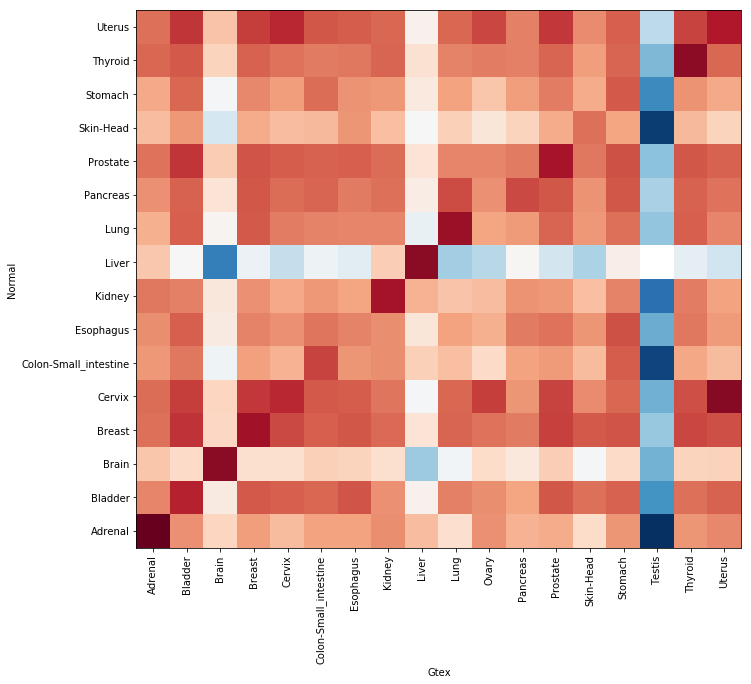

In [58]:
h = hv.HeatMap(dataset.aggregate(['Gtex', 'Normal'], np.mean))
h(opts)

## Normal vs. Tumor

In [36]:
hm = create_heatmap_dataframe(df, 'normal', 'tumor')
dataset = hv.Dataset(hm, vdims=['dist'])

:HeatMap   [Normal,Tumor]   (dist)
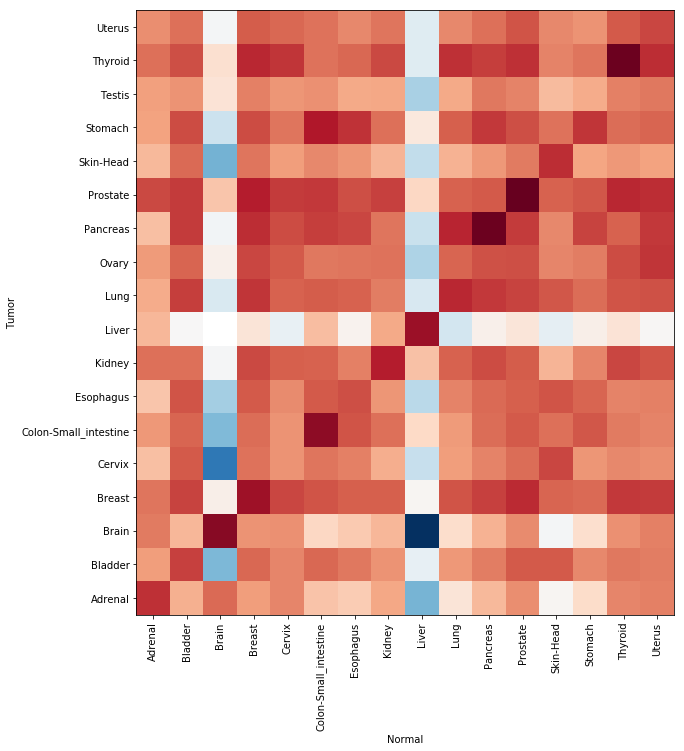

In [54]:
h = hv.HeatMap(dataset.aggregate(['Normal', 'Tumor'], np.mean))
h(opts)

## GTEx vs. Tumor

In [59]:
hm = create_heatmap_dataframe(df, 'gtex', 'tumor')
dataset = hv.Dataset(hm, vdims=['dist'])

In [62]:
%%output fig="svg"
h = hv.HeatMap(dataset.aggregate(['Gtex', 'Tumor'], np.mean))
h(opts)

:HeatMap   [Gtex,Tumor]   (dist)